# Indeed Job Analysis
Martha Gavidia

CSIT 505 Python Programming

## Overview:

This project aims to draw insights from job postings on Indeed.com with the keywords: Data Science, Machine Learning, Natural Language Processing and Unstructured Data.  For each keyword, I looked at all jobs within 25 miles of Newark, NJ.  The goal is to create meaningful visualizations that summarize which positions are available and where, what employers are looking for, and how much they are paying.  As I aspire to enter the tech field, I thought it important to see what the job market in this area is like as I begin planning the next steps in my career.  Understanding what employers are looking for will help guide me through this journey.

After having reviewed the Terms of Service for Indeed.com I found that web scraping, even publicly available information, is strictly prohibited without the written consent from Indeed.  I reached out to Indeed and have written permission via email correspondance to scrape their site for the purposes of this project.  While this notebook will not go over the webscraping process, I have included the python script, with detailed comments, in my github repository which can be found here: https://github.com/marsgav/indeedjobpostings.  

The following goes through each step of the coding process including cleaning the data as well as creating visualizations.  References are listed at the end for sources that were helpful tools in compiling all of this information.

So, let's begin!

## Libraries:

First, we'll load the libraries needed to carry out this analysis.  Pandas is used to read the csv files created through web scraping and create the dataframe that we'll be working with.  NLTK is a great tool to do some text cleaning, we'll be using this to tokenize and remove stop words from our Description data.  Next, we'll use some regular expressions for further text cleaning and the collections library with the Counter module helps with summarizing our data.  Matplotlib is used for our bar graphs and WordCloud will create a fun visualization to summarize job titles.

In [1]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud

Since several keywords were used for our analysis, each had it's own .csv file.  In order to look at them together, we'll use Pandas to read each file and then concatenate them into one single dataframe.  When concatenating, we will need to drop duplicates because there was some overlapping in jobs within the keywords used. 

In [2]:
#reads all csvs created from webscraping
df1 = pd.read_csv("datascience.csv", encoding = "utf-8")
df2 = pd.read_csv("ml.csv", encoding = "utf-8")
df3 = pd.read_csv("nlp.csv", encoding = "utf-8")
df4 = pd.read_csv("unstrucdata.csv", encoding = "utf-8")
#concatenates all files into single dataframe dropping duplicates
df= pd.concat((df1,df2,df3,df4), axis =0).drop_duplicates()
#returns (975,5) for 975 rows in 5 columns
df.shape
#saves dataframe to single csv file
#df.to_csv(r'/Users/marthagavidia/Downloads/indeedproject/allindeedjobs.csv') 

(975, 5)

## Companies:

The first thing we want to find out is who exactly is hiring in this area.  Having merged all the documents into one single dataframe we can easily call upon the dataframe and specify that we want to look at the Company column and get a count for each company that has a job posting.

In [3]:
df.Company.value_counts()

Amazon.com Services LLC      34
Bloomberg                    18
CITI                         15
Spotify                      11
Amazon Web Services, Inc.    11
                             ..
TapRecruit                    1
Galvanize                     1
GNY Insurance Companies       1
Sensentia                     1
Medium                        1
Name: Company, Length: 535, dtype: int64

Here, we get an abbreviated list of companies and can see that Amazon is listed as both Amazon.com Services LLC and Amazon Web Service, Inc.  We'll combine the two with the following code and see if there is any other overlap in companies when we look at the Top 20 companies with the most job postings in this area.

In [4]:
#We call upon the df specifying the Company and use .replace to replace the text.  
#The original text is provided then the desired change.
df.Company = df.Company.replace("Amazon.com Services LLC", "Amazon") 
df.Company = df.Company.replace("Amazon Web Services, Inc.", "Amazon") 

Now that we've combined the names, we can create a bar graph using Matplotlib. 

First, we create the variable company_counts that is the list of top 20 companies that have job postings.  We name the x axis, give the graph a title and add in the values on the graph itself for better reading. 

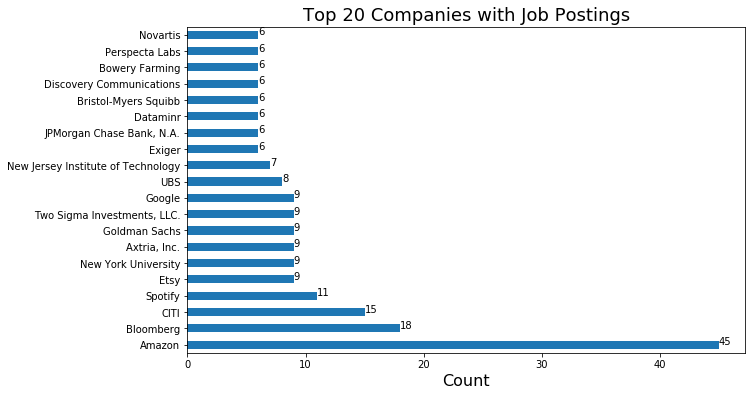

In [25]:
#parts of code learned and adapted from https://stackoverflow.com/questions/30228069/how-to-display-the-value-of-the-bar-on-each-bar-with-pyplot-barh
#graph of top 20 companies with the most listings
company_counts= df.Company.value_counts()[:20]
#barh creates horizontal graph
company_counts.plot.barh(figsize=(10,6))
plt.xlabel('Count', fontsize=16)
plt.title('Top 20 Companies with Job Postings',fontsize=18)
#this includes the values
for index, value in enumerate(company_counts):
    plt.text(value, index, str(value))

Amazon is merged and there is no overlap in the top 20 companies so we'll move on.  Interestingly enough, while it is no surprise that Google and Amazon are top companies looking to fill positions, so are universities like Columbia, NJIT and NYU.  Getting the top 20 companies looking to fill positions gives us a starting point as to where to begin our job search!

## Locations:

Now, we'll look at locations.  Knowing that Amazon is the company with the most listings we can assume that the majority of jobs will more than likely be in New York.  But, what if we wanted to stay in New Jersey?  Let's find out which towns in New Jersey have companies looking to fill positions, too.

In [6]:
df.Location.value_counts()

New York, NY                                   416
New York, NY 10010 (Flatiron District area)     24
New York, NY 10017 (Midtown area)               23
New York, NY 10011 (Flatiron District area)     20
New York, NY 10003 (Flatiron District area)     18
                                              ... 
East Hanover, NJ                                 1
New York, NY 10027 (Harlem area)                 1
Brooklyn, NY 11206 (Williamsburg area)           1
Union City, NJ                                   1
Little Falls, NJ 07424                           1
Name: Location, Length: 143, dtype: int64

Above, we get an abbreviated list of locations but it's a bit messy.  Let's clean this information a bit so that we can get accurate counts.  We can drop the zip codes and everything within parentheses.  Looking at this list, we see that what is in parentheses are just areas of Manhattan so we can group them all as Manhattan.

We'll define a function that uses regular expressions to clean our data.  We know we want to drop the digits of the zip codes as well as everything in parentheses so our first if statement says that we're looking for everything that comes before a digit and the start() returns the index of what is matched.  Having the index means that we can return the position of the first part only and that's what we do with [:pos].  We apply the function to the entire Location column and store it under the variable clean_loc.  Then we use the same .replace function we used earlier, to change everything that is New York, NY to Manhattan, NY and graph the top 20 locations.

In [9]:
#code learned and adapted from https://www.geeksforgeeks.org/replace-values-in-pandas-dataframe-using-regex/
def clean_loc(loc_name):
    if re.search(' \d.*', loc_name):
        pos= re.search(' \d.*', loc_name).start()
        return loc_name[:pos]
    elif re.search('\(.*', loc_name):
        pos= re.search(' \(.*', loc_name).start()
        return loc_name[:pos]
    else:
        return loc_name
    
clean_loc= df["Location"] = df["Location"].apply(clean_loc)
df["Location"]= df["Location"].replace("New York, NY", "Manhattan, NY") 

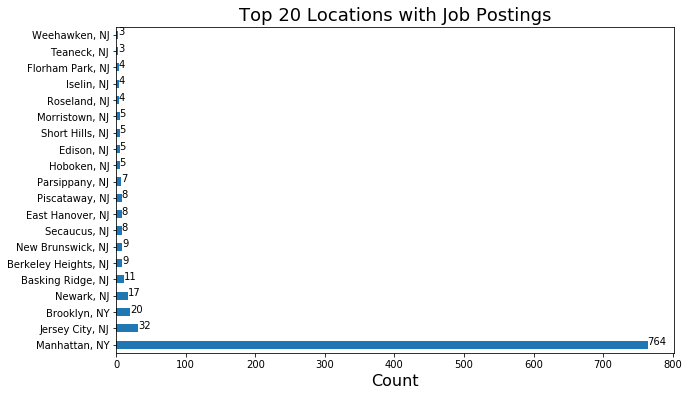

In [10]:
#graph of top 20 locations with the most listings
loc_counts= clean_loc.value_counts()[:20]
#barh creates horizontal graph
loc_counts.plot.barh(figsize=(10,6))
plt.xlabel('Count', fontsize=16)
plt.title('Top 20 Locations with Job Postings',fontsize=18)
#this includes the values
for index, value in enumerate(loc_counts):
    plt.text(value, index, str(value))

So, we were right! New York has the most job postings but let's look at New Jersey.  Jersey City has the second highest location count which is great because it is still in close proximity to the city but saves you the commute!  But, since we searched for jobs within 25 miles of Newark, let's find out what companies and positions are available there.  We'll do this by setting Newark, NJ as the Location and returning all of the Companies and their respective positions.

In [11]:
df[df['Location']== "Newark, NJ"][['Company', 'Title']] 

,Company,Title
81,Prudential,Senior Big Data Engineer
122,Infotree Service Inc,Data Engineer / Data Consultant / Data Scienti...
137,New Jersey Institute of Technology,Professor of Practice-MIS/Business Data Science
287,AeroFarms,Senior Data Engineer
304,"Audible, Inc.",Software Development Engineer – Adobe Product ...
310,Fresh Gravity,Consultant / Sr. Consultant - MDM Analyst
336,CDW,Associate Consulting Engineer – Federal (Data ...
119,New Jersey Institute of Technology,Visiting Scientist
173,New Jersey Institute of Technology,Research Scientist (Software Security)
189,New Jersey Institute of Technology,Postdoctoral Research Associate


Here we see NJIT has several positions available!

## Titles:

Lets' take a brief look into titles.  
Below we created a Word Cloud of the top 20 job position titles. What stood out to me was the usage of the words Senior, Lead, Principal, Head, etc.  We'll want to use these keywords to see how often they actually come up in the descripton and also look for opposing words like Junior, Associate, Entry, Intermediate, etc.

In [12]:
title_counts = df.Title.value_counts().sort_values(ascending = False)[:20]

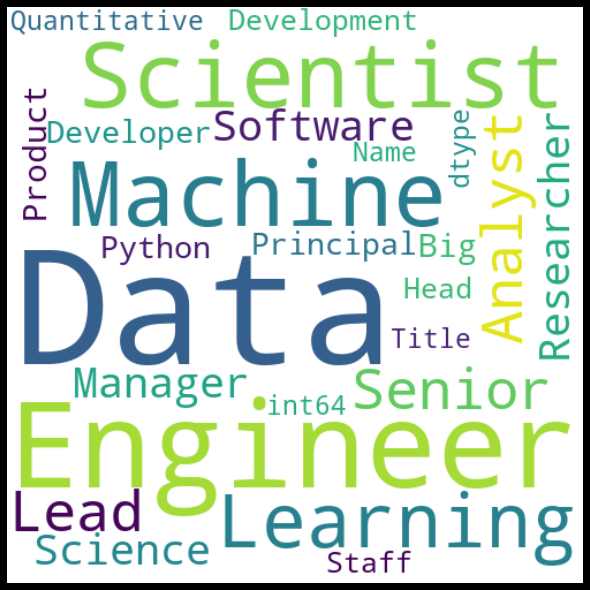

In [13]:
#code learned and adapted from https://www.datacamp.com/community/tutorials/wordcloud-python
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
text = [title_counts]
wordcloud = WordCloud(
    width = 500,
    height = 500,
    background_color = 'white',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (8, 8),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [14]:
title_counts

Data Scientist                     41
Data Engineer                      29
Senior Data Engineer               24
Senior Data Scientist              21
Data Analyst                       10
Machine Learning Engineer           9
Lead Data Scientist                 6
Product Manager                     6
Big Data Engineer                   4
Software Engineer                   4
Principal Data Scientist            4
Python Developer                    4
Lead Data Engineer                  4
Data Science Analyst                3
Software Development Engineer       3
Staff Machine Learning Engineer     3
Machine Learning Researcher         3
Head of Data Science                3
Machine Learning Manager            3
Quantitative Researcher             3
Name: Title, dtype: int64

## Description:

The description column required the most cleaning and so we took advantage of the NLTK library to make this task easier.  We'll define a function to tokenize, make all the characters lowercase, remove stop words (we've added additional stop words to simplify the text).  We'll create a new column called Clean_Desc to store our data and then apply the function.  We can print it to get a quick look and the output. 

In [15]:
#code learned and adapted from CodeHeroku
stop_words = stopwords.words('english')
new_stopwords = ['equal', 'opportunity', 'employer', 'sexual', 'orientation', 'candidate', 'gender', 'race', 'color', 'religion', 'new', 'york', 'protected', 'veteran', 'regard', 'identity', 'national', 'origin', 'age', 'employment', 'qualified', 'applicants', 'receive', 'consideration', 'sex', 'join', 'us', 'team', 'members', 'track', 'record', 'around' ,'world' ,'status', 'disability', 'marital', 'working', 'work', 'closely', 'job', 'description', 'best', 'practices', 'internal', 'external', 'etc', 'united', 'states']
stop_words.extend(new_stopwords)

def clean_desc(desc):
    desc = word_tokenize(desc)
    desc = [word.lower() for word in desc if word.isalnum()]
    desc = [word for word in desc if word not in stop_words]
    #desc = list(nltk.trigrams(desc)) we'll use this later
    return desc

df["Clean_Desc"] = df["Description"].apply(clean_desc)
df.Clean_Desc

0      [note, position, accepting, texas, skills, exc...
1      [field, data, science, growing, hunt, talented...
2      [background, major, financial, services, clien...
3      [business, group, highlights, perspecta, labs,...
4      [relocation, assistance, offered, 83932, pisca...
                             ...                        
181    [cloud, spark, developer, remote, position, re...
182    [since, founding, 1919, school, tns, redrawn, ...
183    [advert, canddates, must, fluent, mandarin, wr...
184    [advert, fluent, spanish, portuguese, preferre...
185    [asg, legaltech, marketing, operations, manage...
Name: Clean_Desc, Length: 975, dtype: object

Now that we have our text cleaned we can start looking for the occurences of certain words.  We will need to use the Counter module to get a count of all of the words in the text and get the total sums.  With that, we can use the sorted function to sort all of the word counts.  The sorted function requires the following parameters: sorted(iterable, *, key=None, reverse=False).  In this case, the first parameter is the result which contains the sum of counts, next we   have the key function, which according to Python documentation says that, "key parameter should be a function that takes a single argument and returns a key to use for sorting purposes" and the third parameter just lists the sorted list in descending order.  We'll have a key as the word and the value is the count.  Having defined kv for our sorted list, we'll create a variable containing the key words we want to examine and extract those counts.

#### Skill Level:

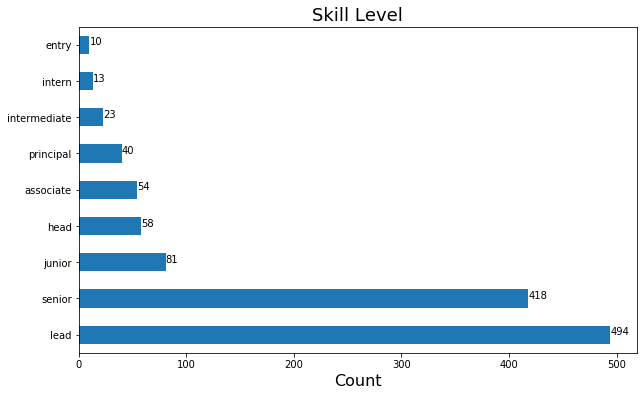

In [26]:
#code learned and adapted from CodeHeroku
result = df.Clean_Desc.apply(Counter).sum().items()
result = sorted(result, key=lambda kv: kv[1],reverse=True)
result_series = pd.Series({k: v for k, v in result})
keywords1 = ["senior", "lead", "head", "principal", "intern", "junior", "associate", "entry", "intermediate"]

filter_series = result_series.filter(items=keywords1).sort_values(ascending = False)
filter_series.plot.barh(figsize=(10,6))
plt.xlabel('Count', fontsize=16)
plt.title('Skill Level',fontsize=18)
#this includes the values
for index, value in enumerate(filter_series):
    plt.text(value, index, str(value))

The results of our keywords search shows that most employers are looking for lead/senior level people which is understandable but obviously not great for people trying to emerge into this field.  However, it's important to know what exactly that means- we'll look at what the degree requirements are, which programming languages are the most sought out and how many years experience is the standard.

#### Degree Qualifications:

Let's find out how many descriptions list Bachelor, Master and Phd.

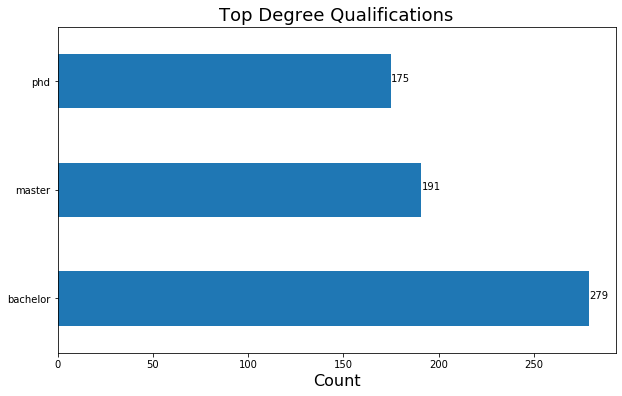

In [17]:
keywords2 = ["bachelor", "master", "phd"]

filter_series = result_series.filter(items=keywords2).sort_values(ascending = False)
filter_series.plot.barh(figsize=(10,6))
plt.xlabel('Count', fontsize=16)
plt.title('Top Degree Qualifications',fontsize=18)
#this includes the values
for index, value in enumerate(filter_series):
    plt.text(value, index, str(value))

279 job postings mention a Bachelor degree!  So, even though this isn't representative of every job posting, the consensus seems to be that while lead/senior positions are being sought out the most, this doesn't mean that someone holding a Bachelor's degree in the field can't apply nor should one feel like a Phd is absolutely necessary to find a good job.

#### Programming Languages:

The following article, https://towardsdatascience.com/top-9-languages-for-data-science-in-2020-824239f930c, highlights the top programming languages that are good for data science so let's see how each is represented in the description data.

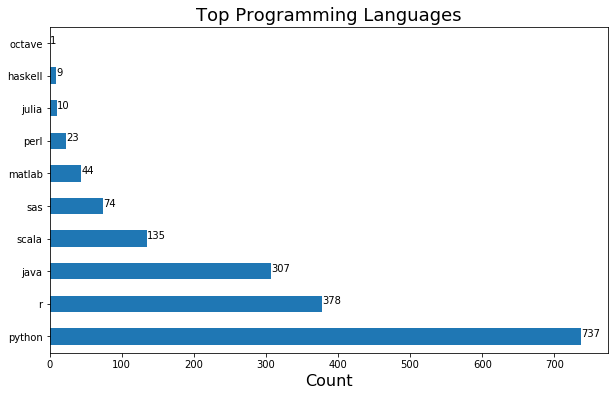

In [18]:
keywords3 = ["python", "r", "scala", "sas", "julia", "matlab", "octave", "java", "perl", "haskell"]

filter_series = result_series.filter(items=keywords3).sort_values(ascending = False)
filter_series.plot.barh(figsize=(10,6))
plt.xlabel('Count', fontsize=16)
plt.title('Top Programming Languages',fontsize=18)
#this includes the values
for index, value in enumerate(filter_series):
    plt.text(value, index, str(value))

Python is very much in the lead and considering this is a Python course, afterall, we seem to be on the right track!

#### Experience:

In order to look for the standard "years of experience" required we'll need to change our original code a bit.
The code above splits words into single ngrams which is good for sorting out single words but if we were to need to look for bigrams or trigrams then the code would need to be adjusted to create bi/trigrams and then we can search sequences of words together.  We'll be looking at trigrams such as, "3 years experience", "5 years experience" and "7 years experience".  In order to preserve our original code, we'll create another function clean_desc_tri and apply it to a new column Clean_Desc_tri.

In [20]:
def clean_desc_tri(desc):
    desc = word_tokenize(desc)
    desc = [word.lower() for word in desc if word.isalnum()]
    desc = [word for word in desc if word not in stop_words]
    desc = list(nltk.trigrams(desc))
    return desc

df["Clean_Desc_tri"] = df["Description"].apply(clean_desc_tri)
df.Clean_Desc_tri

0      [(note, position, accepting), (position, accep...
1      [(field, data, science), (data, science, growi...
2      [(background, major, financial), (major, finan...
3      [(business, group, highlights), (group, highli...
4      [(relocation, assistance, offered), (assistanc...
                             ...                        
181    [(cloud, spark, developer), (spark, developer,...
182    [(since, founding, 1919), (founding, 1919, sch...
183    [(advert, canddates, must), (canddates, must, ...
184    [(advert, fluent, spanish), (fluent, spanish, ...
185    [(asg, legaltech, marketing), (legaltech, mark...
Name: Clean_Desc_tri, Length: 975, dtype: object

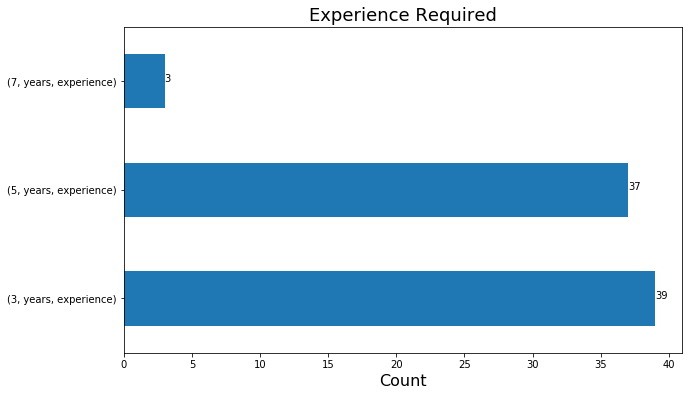

In [21]:
result2 = df.Clean_Desc_tri.apply(Counter).sum().items()
result2 = sorted(result2, key=lambda kv: kv[1],reverse=True)
result_series2 = pd.Series({k: v for k, v in result2})
keywords3 = [("3", "years","experience"), ("5","years","experience"), ("7","years","experience")]

filter_series2 = result_series2.filter(items=keywords3).sort_values(ascending = False)
filter_series2.plot.barh(figsize=(10,6))
plt.xlabel('Count', fontsize=16)
plt.title('Experience Required',fontsize=18)
#this includes the values
for index, value in enumerate(filter_series2):
    plt.text(value, index, str(value))

3 years experience takes the lead here but it's important to acknowledge that it does represent only a small portion of jobs, in any case it's good to gauge how many years experience is, seemingly, the standard.

## Salary:

Finally, we'll look at salaries.  Most job postings did not include their salary so we'll only look at those that did include that information for our analysis.  Here we'll create a variable df_salary for the job postings that do list a salary and print the dataframe where we will also see the new Clean_Desc and Clean_Desc_tri columns we created earlier.

In [22]:
df_salary = df[df["Salary"]!= "None"]
df_salary

,Title,Location,Company,Salary,Description,Clean_Desc,Clean_Desc_tri
2,Head of Data Science,"Manhattan, NY",Parallel Consulting Inc,"$180,000 - $220,000 a year",Background:\nA Major Financial services client...,"[background, major, financial, services, clien...","[(background, major, financial), (major, finan..."
5,Data Scientist,"Manhattan, NY",Glean,"$100,000 - $140,000 a year",Data Science @ Glean\nNew York City / Remote O...,"[data, science, glean, city, remote, ok, glean...","[(data, science, glean), (science, glean, city..."
6,Big Data Engineer,"Parsippany, NJ",Brevco Services,$30 - $35 an hour,Job Title: Big Data Engineer\nLocation: Parsip...,"[title, big, data, engineer, location, parsipp...","[(title, big, data), (big, data, engineer), (d..."
8,Data Science Online Course Instructor (Part-Ti...,"Manhattan, NY",DataCamp,"From $150,000 a year","Please note that this is a part-time, contract...","[please, note, contract, remote, position, exp...","[(please, note, contract), (note, contract, re..."
11,"Big Data Developer / Engineer in Jersey city, ...","Jersey City, NJ",Koreminds LLC,$65 - $80 an hour,Position: Big Data Developer / Engineer\nLocat...,"[position, big, data, developer, engineer, loc...","[(position, big, data), (big, data, developer)..."
...,...,...,...,...,...,...,...
53,SQL Developer,"Manhattan, NY",Ace-stack LLC,$65 an hour,Job Details\nPosition : SQL Developer\nExpert ...,"[details, position, sql, developer, expert, kn...","[(details, position, sql), (position, sql, dev..."
127,COMPUTER SYSTEMS MANAGER,"Brooklyn, NY",New York City NYC EMPLOYEES RETIREMENT SYS,"$54,643 - $150,371 a year",NYCERS IT Division seeks a Database Manager to...,"[nycers, division, seeks, database, manager, s...","[(nycers, division, seeks), (division, seeks, ..."
147,Java Developer,"Manhattan, NY",Insight Global,"$160,000 - $180,000 a year",Insight Global is looking for a Senior Java De...,"[insight, global, looking, senior, java, devel...","[(insight, global, looking), (global, looking,..."
179,Pre-K or 4th Grade Teacher - P.E. Specialist,"Manhattan, NY",The Equity Project Charter School,"$125,000 a year","Earn a $125,000 salary and join a team of mast...","[earn, salary, master, teachers, equity, proje...","[(earn, salary, master), (salary, master, teac..."


As we can see, the formatting is different for each.  Some give salary amounts per year, per month or per hour so we'll need to clean up this data as well.

In order to clean this data, we'll define a function that goes through each row of the Salary column and finds all occurences of where there is a "-" having found that, we'll split based on that position and count the first position [0] as the minimum and the second position [1] as the maximum.  If there is no "-" then we'll just keep it as the salary.  Then, we'll use the .replace function again to get rid of words like "month", "year", etc.  Additionally, because we are looking for annual salaries we need to normalize our data, so we'll multiply monthly salaries by 12, daily salaries by 261 (Google says there are 261 working days in the year) and hourly salaries by 2080 which is based off of 40 hr work weeks.  We'll apply the function to df_salary and then print out the top 5 just to make sure the new min and max columns appear correctly.

In [27]:
#code learned and adapted from CodeHeroku
def format_salary(row):
    salary = row["Salary"]
    if "-" in salary:
        split = salary.split("-")
        salary_min = split[0]
        salary_max = split[1]
    else:
        salary_min = salary
        salary_max = salary
    
    row["salary_min"] = salary_min.replace("$","").replace("a month","").replace("a year","").replace(",","").replace("a day","").replace("an hour","").replace("From ","")
    row["salary_max"] = salary_max.replace("$","").replace("a month","").replace("a year","").replace(",","").replace("a day","").replace("an hour","").replace("From ","")
       
    if "month" in row["Salary"]:
        row["salary_min"] = int(row["salary_min"])*12
        row["salary_max"] = int(row["salary_max"])*12
    
    if "day" in row["Salary"]:
        row["salary_min"] = int(row["salary_min"])*261
        row["salary_max"] = int(row["salary_max"])*261
        
    if "hour" in row["Salary"]:
        row["salary_min"] = int(row["salary_min"])*2080
        row["salary_max"] = int(row["salary_max"])*2080
    
   
    return row


df_salary = df_salary.apply(format_salary,axis=1) 
df_salary.head()

,Title,Location,Company,Salary,Description,Clean_Desc,Clean_Desc_tri,salary_min,salary_max
2,Head of Data Science,"Manhattan, NY",Parallel Consulting Inc,"$180,000 - $220,000 a year",Background:\nA Major Financial services client...,"[background, major, financial, services, clien...","[(background, major, financial), (major, finan...",180000,220000
5,Data Scientist,"Manhattan, NY",Glean,"$100,000 - $140,000 a year",Data Science @ Glean\nNew York City / Remote O...,"[data, science, glean, city, remote, ok, glean...","[(data, science, glean), (science, glean, city...",100000,140000
6,Big Data Engineer,"Parsippany, NJ",Brevco Services,$30 - $35 an hour,Job Title: Big Data Engineer\nLocation: Parsip...,"[title, big, data, engineer, location, parsipp...","[(title, big, data), (big, data, engineer), (d...",62400,72800
8,Data Science Online Course Instructor (Part-Ti...,"Manhattan, NY",DataCamp,"From $150,000 a year","Please note that this is a part-time, contract...","[please, note, contract, remote, position, exp...","[(please, note, contract), (note, contract, re...",150000,150000
11,"Big Data Developer / Engineer in Jersey city, ...","Jersey City, NJ",Koreminds LLC,$65 - $80 an hour,Position: Big Data Developer / Engineer\nLocat...,"[position, big, data, developer, engineer, loc...","[(position, big, data), (big, data, developer)...",135200,166400


Our salary_min and salary_max columns look good!  For the 1st and 2nd postings we see the salaries are split cleanly and in the 3rd and 5th listings we see the normalized amounts after taking hourly rates into consideration and we also see that the 4th listing says "From $150,000 a year" and that then is translated as the amount for both min and max.  While we do have numbers in our data they are still considered text so we'll use pandas to_numeric function to transform everything in the salary_mix and max columns into their numeric representations and use the .mean() function to calculate the mean.

In [24]:
df_salary.salary_min = pd.to_numeric(df_salary["salary_min"],'coerce')
df_salary.salary_max = pd.to_numeric(df_salary["salary_max"],'coerce')

print("Average minimum salary: ", df_salary.salary_min.mean())
print("Average maximum salary: ", df_salary.salary_max.mean())

Average minimum salary:  107336.4918032787
Average maximum salary:  141295.54098360657


## Results:

Let's go back and answer the questions we started with!

#### Who is hiring?
Well, Amazon is!  They had 45 job postings, followed by Bloomberg with 18 and CITI with 15.  Universities like NJIT, NYU and Columbia University also had several job postings.

#### Where are they hiring?
The top location with job postings was Manhattan, NY, which isn't surprising but if you want to stay in New Jersey check out Jersey City, Newark, Basking Ridge and Berkely Heights among others.

#### What positions are available?
Since one of our keywords was, "Data Science", naturally we ended up with a lot of Data Scientist job postings but there were also several postings for Data Engineer, Data Analyst and Machine Learning Engineer.

#### What are employers looking for?
While employers are looking for candidates holding Masters and PhDs, those with Bachelor Degrees are definitely in demand, too!  Additionally, with so many programming languages out there, it can be overwhelming to think that you have to learn them all in order to be successful in the field but, our results showed that Python and R really stood out as the top languages that employers are looking.  Sharpening your skills in only 2 languages sounds a lot more manageable than trying to learn a little bit of everything. As far as experience goes, our results showed that 3 years experience is seemingly the norm.

#### How much are employers paying?
Our salary analysis was not representative of every job posting but it's a good place to start.  Overall, we found that the mean minimum salary is 107k and mean maximum salary is 141k.  This salary range is not bad at all!

## References:

My GitHub repository with csv files:
https://github.com/marsgav/indeedjobpostings

https://www.geeksforgeeks.org/replace-values-in-pandas-dataframe-using-regex/

https://www.datacamp.com/community/tutorials/wordcloud-python

https://stackoverflow.com/questions/30228069/how-to-display-the-value-of-the-bar-on-each-bar-with-pyplot-barh

CodeHeroku:
https://www.youtube.com/watch?v=QiD1lbM-utk&feature=youtu.be
